In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy import integrate
from sklearn.neighbors import KernelDensity

np.random.seed(20200619)

# Create dictionary of ranges
# Keys should match the lab names in the query below
# Are these values correct given the units? Need to check.

lab_ranges = {'ALBUMIN':[3.5, 5.5], 
              'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'GLUCOSE':[70.0, 100.0],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'MAGNESIUM': [1.6,2.6],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145],
              'FREECALCIUM': [1.1, 1.35],
              'WBC': [3.5, 10.5]
             }
lab_unit = {
        'ALBUMIN': 'g/dL', 
        'BICARBONATE': 'mEq/L',
        'BUN': 'mEq/L',
        'CALCIUM': 'mg/dL',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mEq/L',
        'GLUCOSE': 'mg/dL',
        'HEMOGLOBIN': 'g/dL',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'SODIUM':'mmol/L',
        'FREECALCIUM': 'mmol/L',
        'WBC': ''
       }

labs = {
        #'ALBUMIN': 'g/dL', 
        #'BICARBONATE': 'mEq/L',
        #'BUN': 'mEq/L',
        #'CALCIUM': 'mg/dL',
        #'CHLORIDE': 'mEq/L',
        #'CREATININE': 'mEq/L',
        #'GLUCOSE': 'mg/dL',
        'HEMOGLOBIN': 'g/dL',
        #'LACTATE': 'mmol/L',
        #'MAGNESIUM': 'mmol/L',
        #'PHOSPHATE': 'mg/dL',
        #'PLATELET': 'K/uL',
        #'POTASSIUM': 'mEq/L',
        #'SODIUM':'mmol/L',
        #'FREECALCIUM': 'mmol/L',
        #'WBC': ''
       }


data = pd.read_csv("S:/NUS/Year Two/UROPS/firstlab_xy.csv")

mort_data = data[data['mort_icu']==1]
surv_data = data[data['mort_icu']==0]


In [2]:
def ResumeNorm(val1, val2):
    norm_val1 = norm.ppf(0.025)
    norm_val2 = norm.ppf(0.975)
    mean = (val2 - val1)/2 + val1
    scale = (val1 - val2) / (norm_val1 - norm_val2)
    return norm(mean, scale)

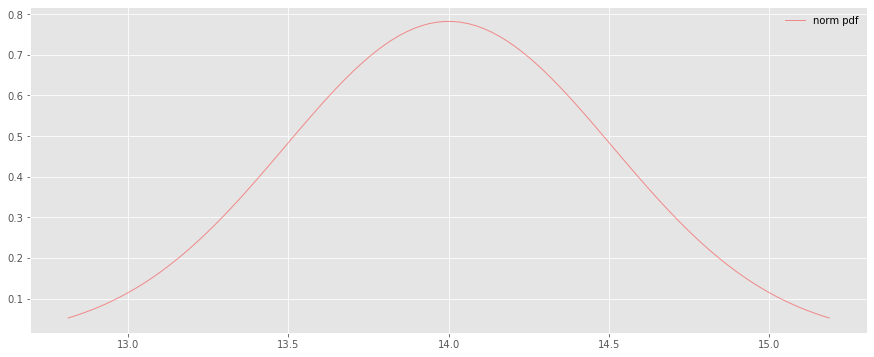

In [3]:
# test resumenorm
val1 = 13
val2 = 15
norm_val1 = norm.ppf(0.025)
norm_val2 = norm.ppf(0.975)
mean = (val2 - val1)/2 + val1
scale = (val1 - val2) / (norm_val1 - norm_val2)
rv = norm(mean, scale)

fig, ax = plt.subplots(figsize=(15, 6))
#mean, var, skew, kurt = norm.stats(moments='mvsk')
x = np.linspace(rv.ppf(0.01),
                rv.ppf(0.99), 100)
ax.plot(x, rv.pdf(x), 'r-',#color red 'k-'then black
        lw=1,#linewidth
        alpha=0.4,#RGBA transparency
        label='norm pdf')
ax.legend(loc='best', frameon=False)
plt.show()

In [3]:
def OverlapParam(dist1, dist2):
    """
        Overlapping coefficient: integration of min value of two distribution over R. 
        For chloride, glucose, sodium, use large interval with focus point interval instead. 
    """
    func = lambda x: min(dist1.pdf(x), dist2.pdf(x))
    return integrate.quad(func, -np.inf , np.inf)
    

In [4]:
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

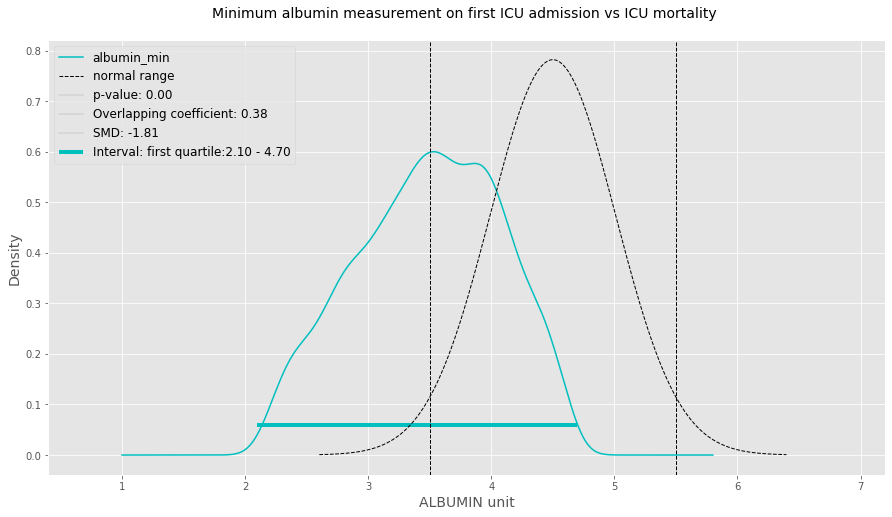

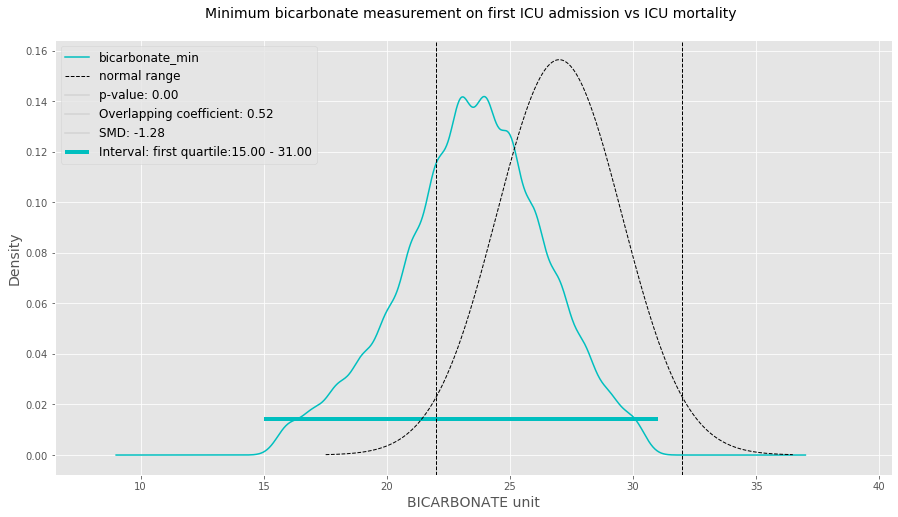

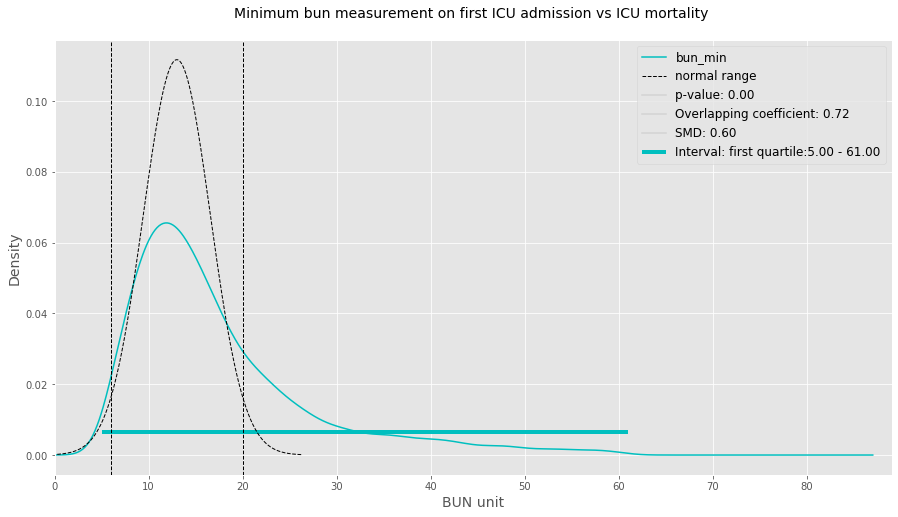

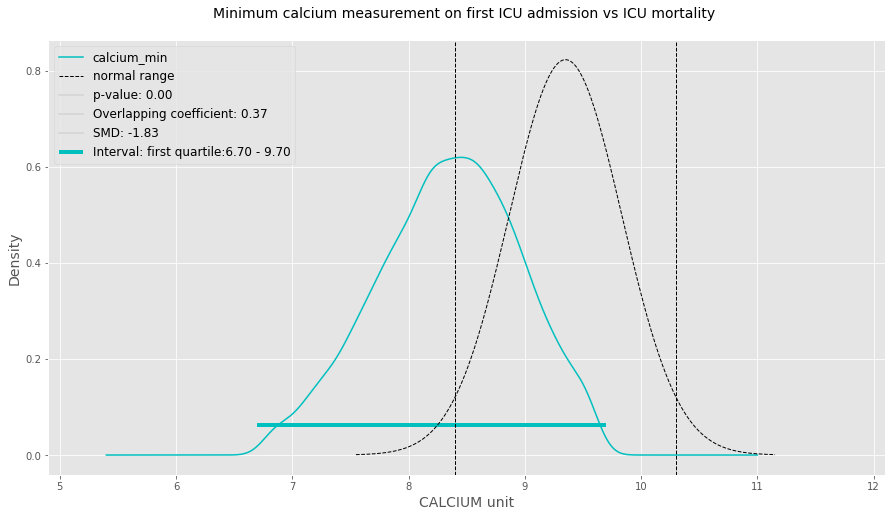

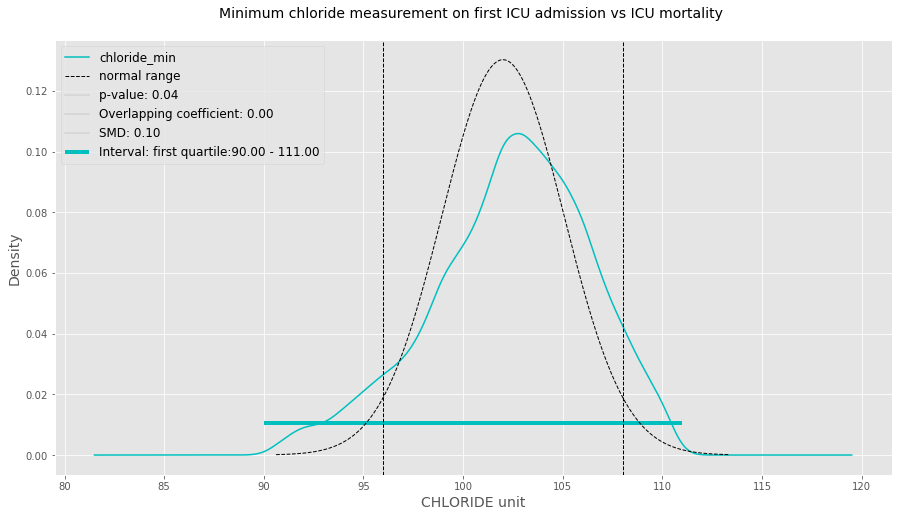

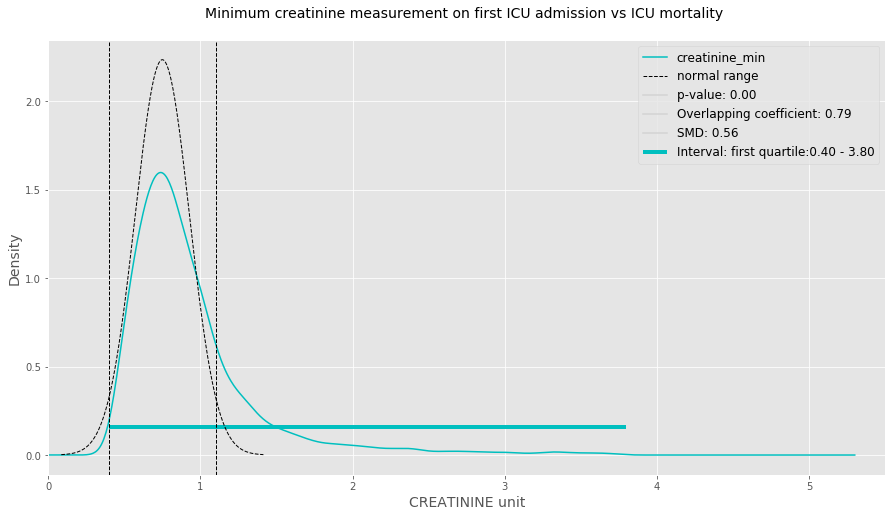

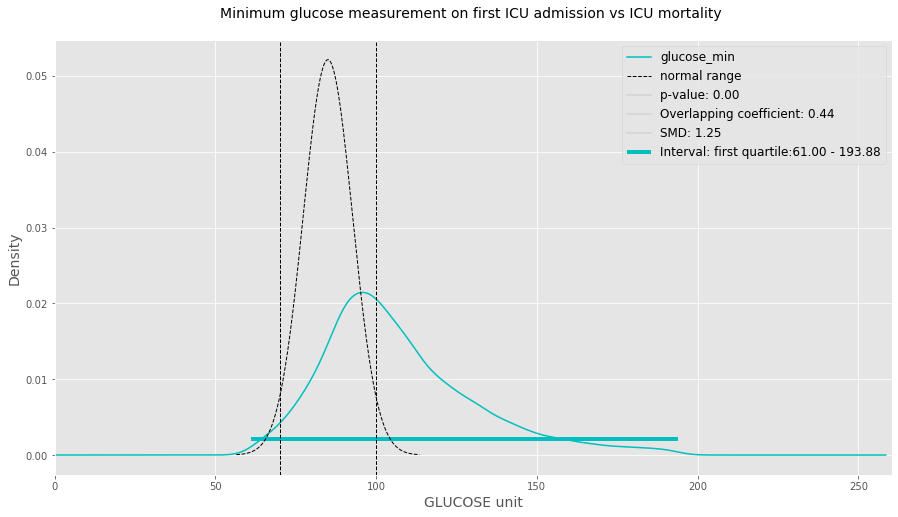

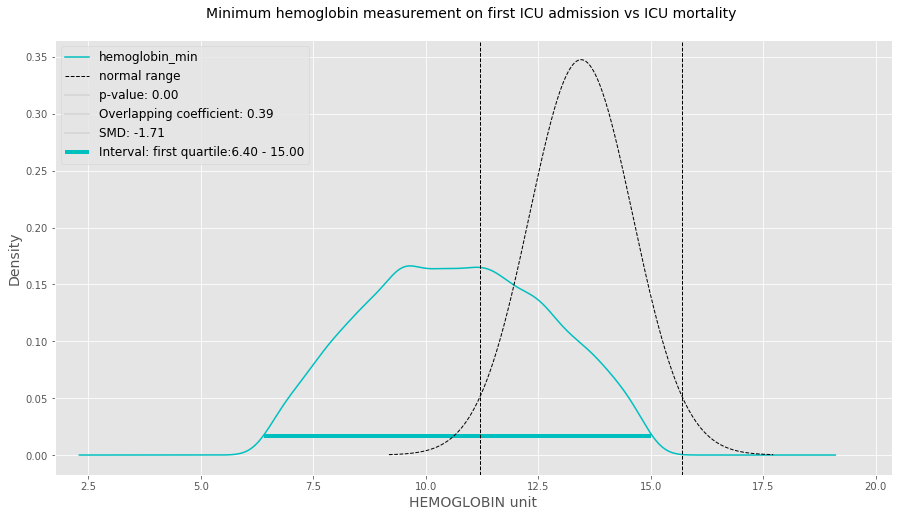

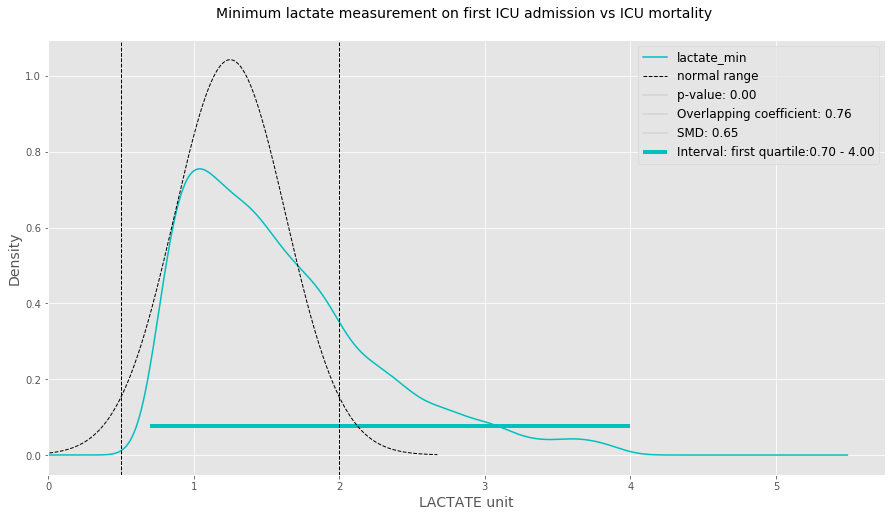

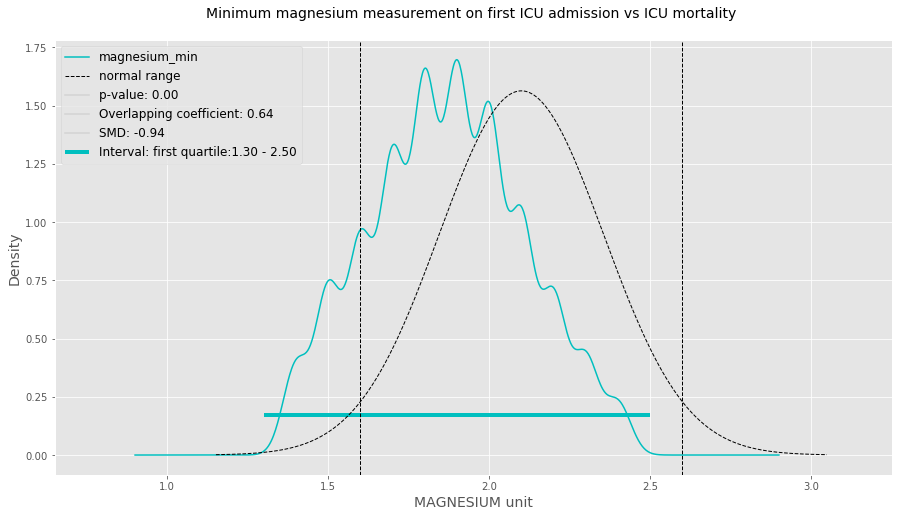

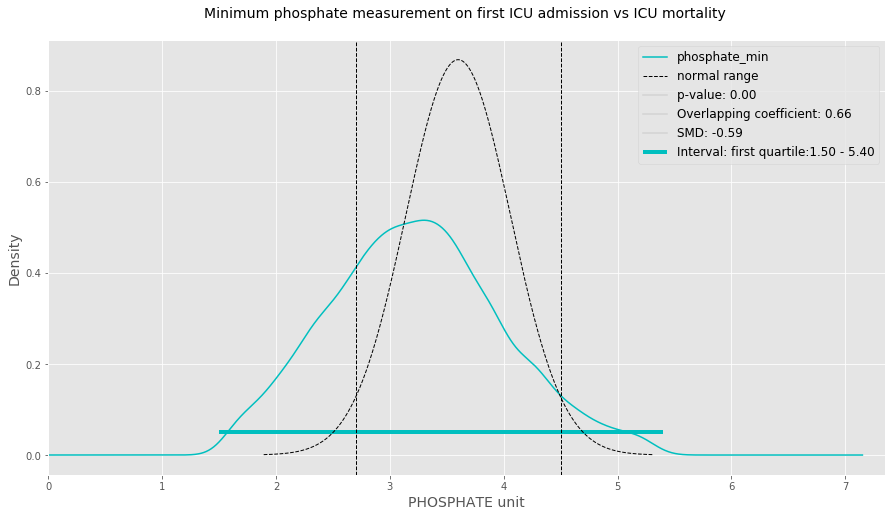

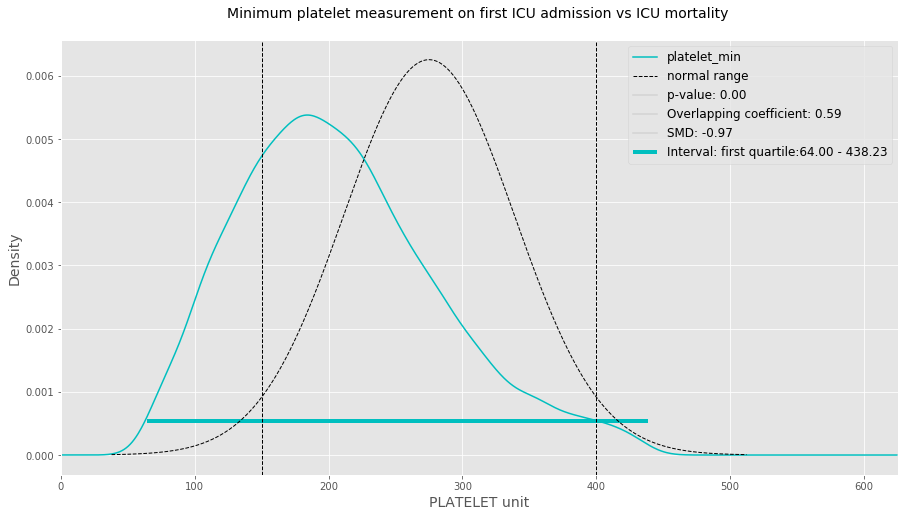

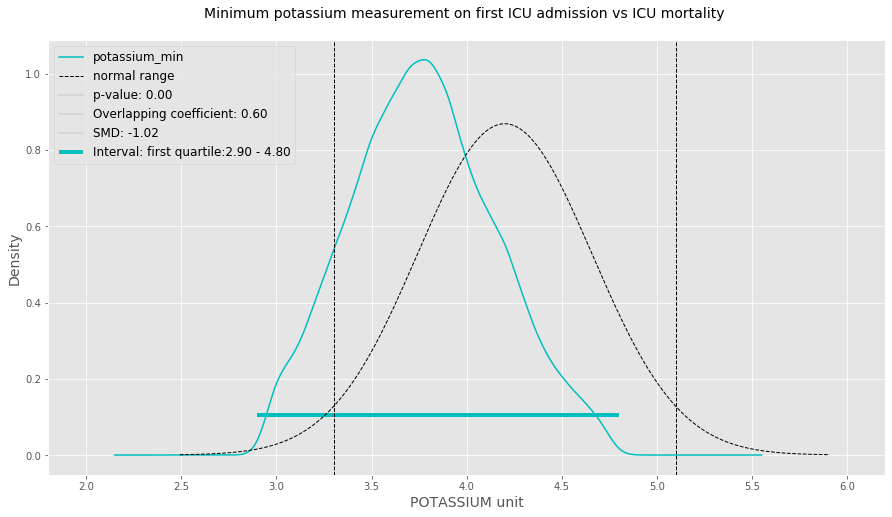

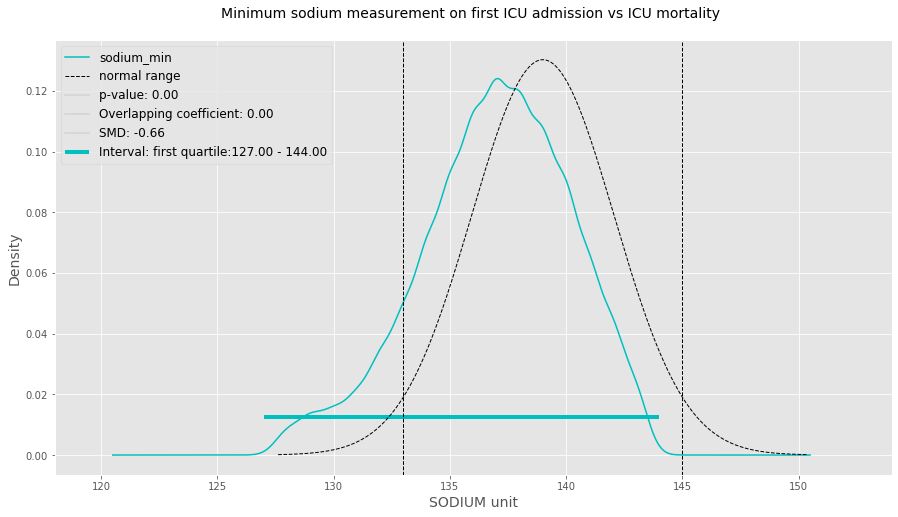

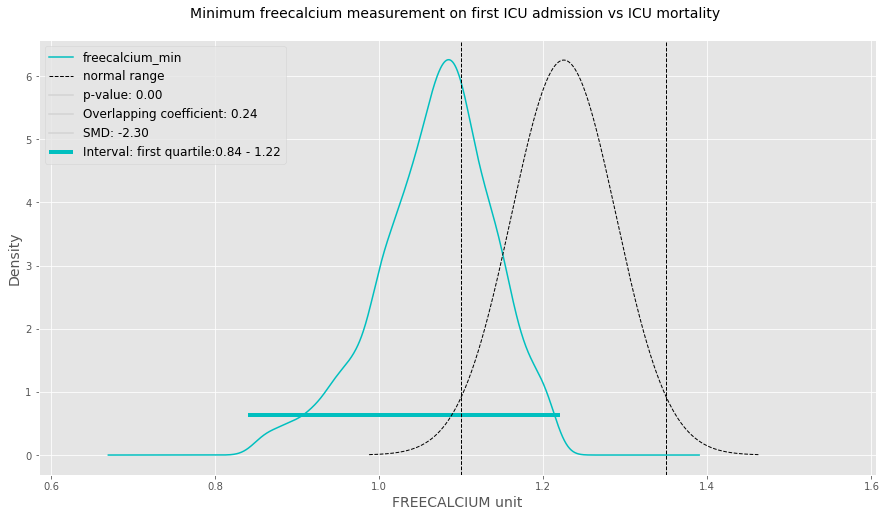

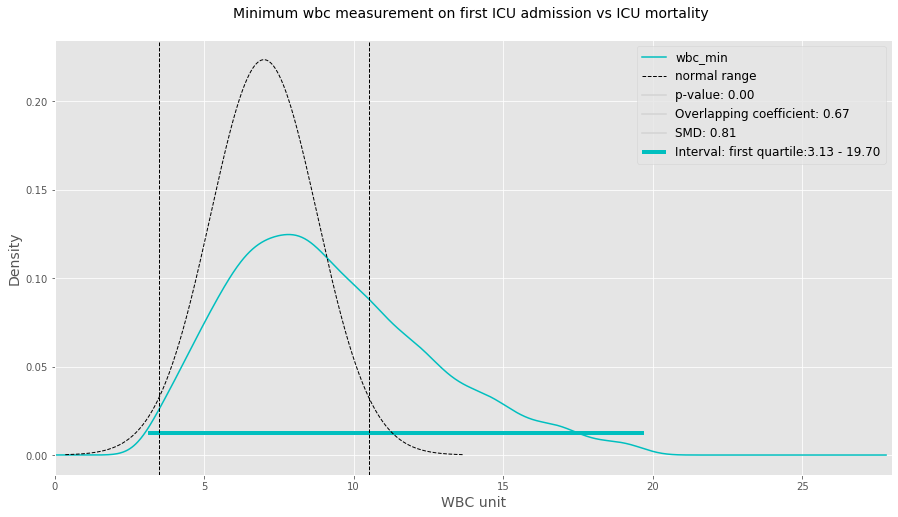

In [15]:

for i, u in iter(lab_unit.items()):
    
    
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    #plot best out come dist
    n_surv = surv_data[i.lower() + '_min'].dropna().count()
    quarter = n_surv /4
    quarter = int(quarter)
    cond = data.mort_icu == 0
    best_group = surv_data.sort_values(by=['los'])[i.lower()+'_min'].dropna().head(quarter)
    [q1, q2] = best_group.quantile(q = [0.025,0.975])
    best_group = best_group[best_group > q1]
    best_group = best_group[best_group < q2]
    '''
    if i.lower == 'magnesium':
        best_group.plot.kde(bw_method='silverman', color='c', label=i.lower()+'_min')
        # is it necessary to specify band width?
    else:
    ''' 
    
    
    #range for x and y
    plot_range = [min(q1,lab_ranges[i][0]),max(q2,lab_ranges[i][1])]
    diff = plot_range[1] - plot_range[0]
    #plt.xlim(max(plot_range[0] - 0.5*diff, 0), plot_range[1] + 0.5*diff)
    
    best_group.plot.kde(color='c', label=i.lower()+'_min', xlim= (max(plot_range[0] - 0.5*diff, 0), plot_range[1] + 0.5*diff))
    
    xs = np.linspace(plot_range[0], plot_range[1], 600)
    density = gaussian_kde(best_group)
    ys = density(xs)
    index = np.argmax(ys)
    maxy = ys[index]
  
    #plot best outcome interval
    #interval line
    plt.hlines(y=0.1*maxy, xmin = q1, xmax = q2, linewidth=4, linestyle='-', color='c', label='Interval(Best Outcome): {} - {}'.format(format(q1,'.2f'), format(q2,'.2f')))
    
    # plot normal range 
    plt.axvline(x=lab_ranges[i][0], linewidth=1, linestyle='--', color='k')
    plt.axvline(x=lab_ranges[i][1], linewidth=1, linestyle='--', color='k')
    
    
    # plot normal distribution with normal range
    norm_dist = ResumeNorm(lab_ranges[i][0], lab_ranges[i][1])
    x = np.linspace(norm_dist.ppf(0.0001),norm_dist.ppf(0.9999), 1000)
    ax.plot(x, norm_dist.pdf(x), 'k-',#color 'r-' red 'k-' black
            lw=1,#linewidth
            alpha=1,#RGBA transparency
            linestyle='--',
            label='normal range')
    ax.legend(loc='best', frameon=False)
    
    #MannWhitney test
    t_stat, p_val = mannwhitneyu(x, best_group)
    
    #standardized mean difference
    norm_sample = norm_dist.rvs(size=quarter, random_state=20200620)
    smd = cohen_d(best_group, norm_sample)
        
    #overlapping parameter
    best_group_dist = gaussian_kde(best_group)
    ovl = OverlapParam(best_group_dist, norm_dist)
        
    plt.plot([], label='p-value: {}'.format(format(p_val, '.2f')), color='lightgrey')
    plt.plot([], label='Overlapping coefficient: {}'.format(format(max(ovl), '.2f')), color='lightgrey')
    plt.plot([], label='SMD: {}'.format(format(smd, '.2f')), color='lightgrey')
    
    plt.title('Minimum {} measurement on first ICU admission '.format(i.lower()) +
                   'vs ICU mortality \n', fontsize=14)
    plt.xlabel(i + ' ' + 'unit', fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)
    plt.savefig("mimic_figure/2group/{}_MIN.png".format(i))
    plt.show()
    


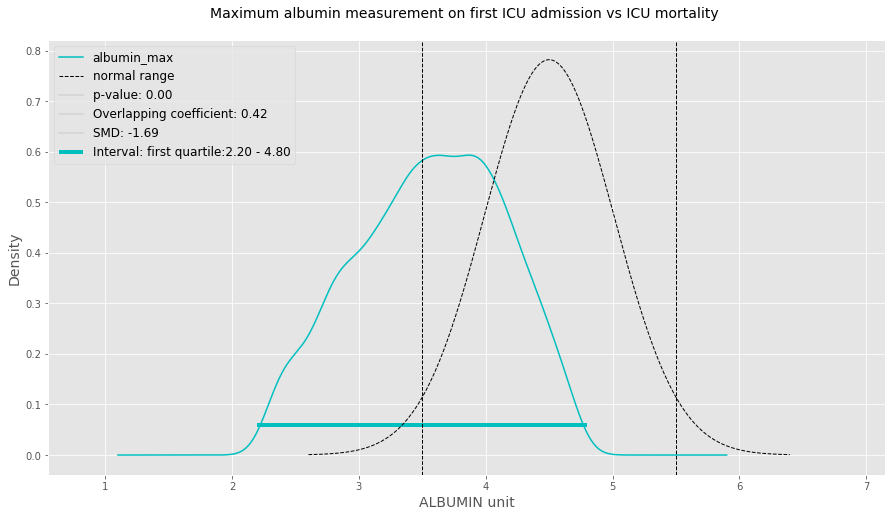

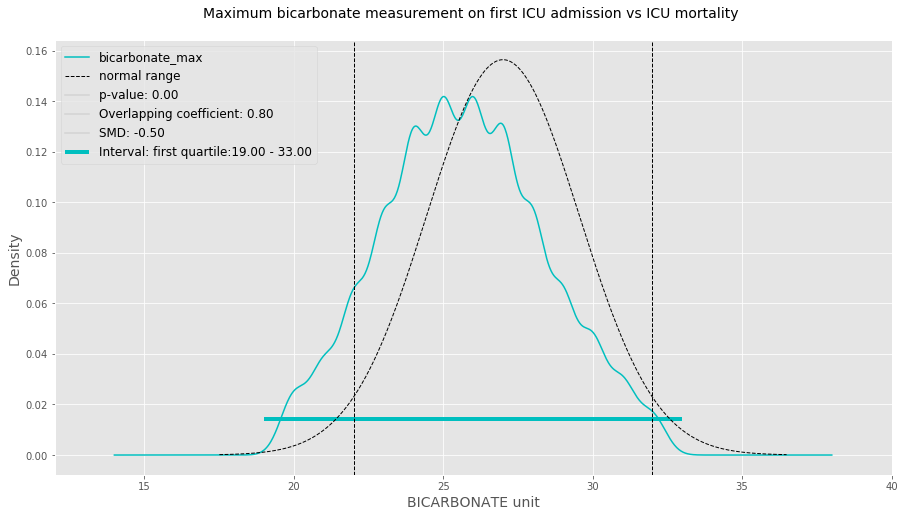

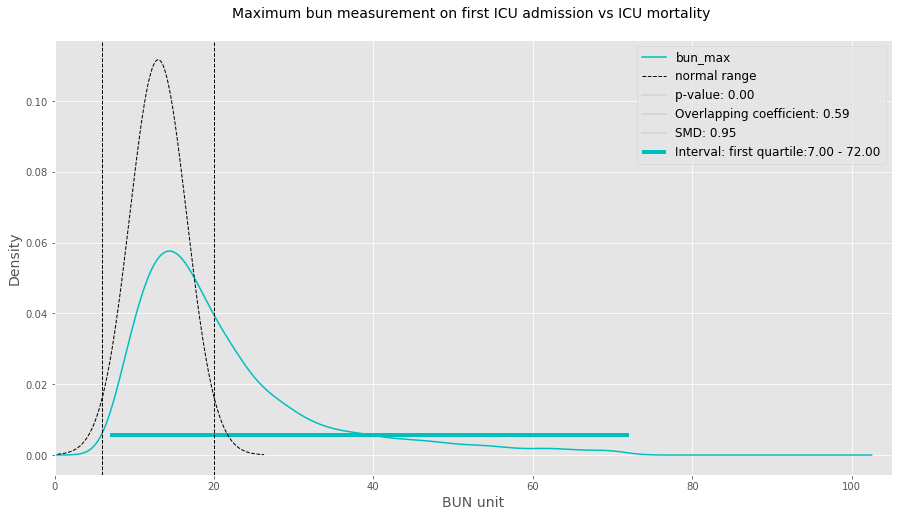

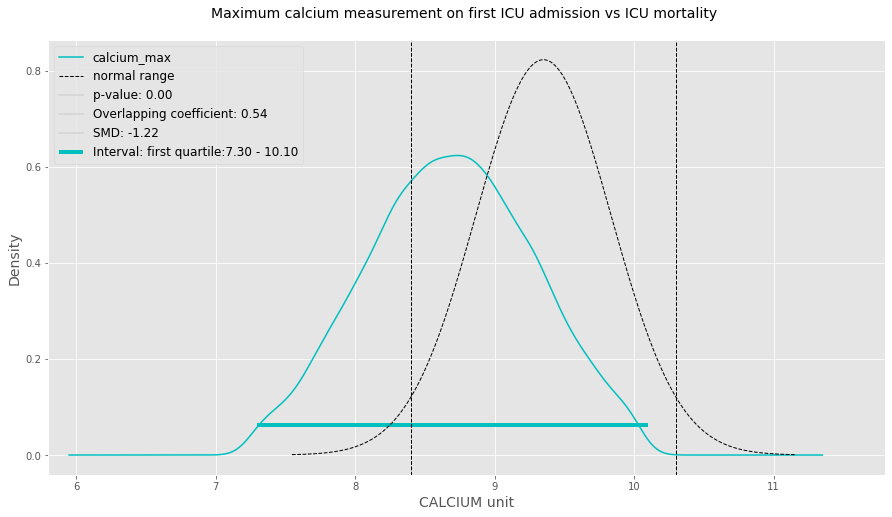

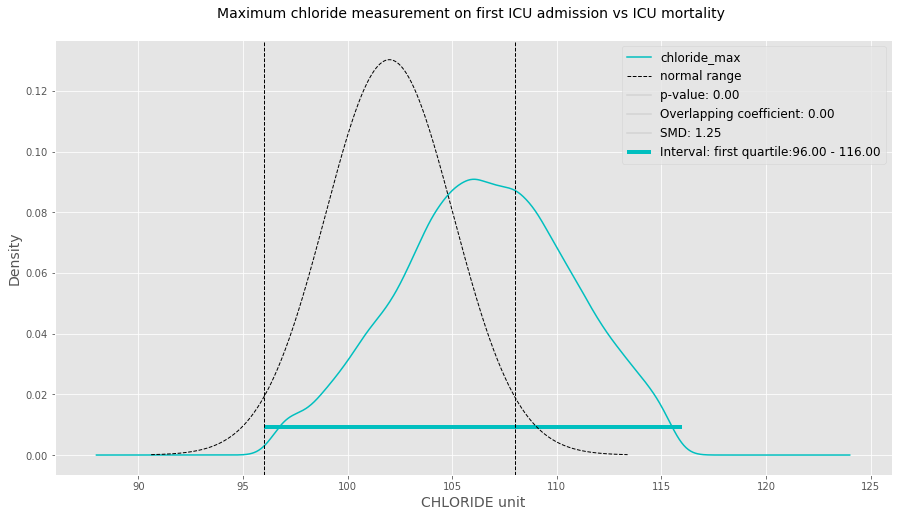

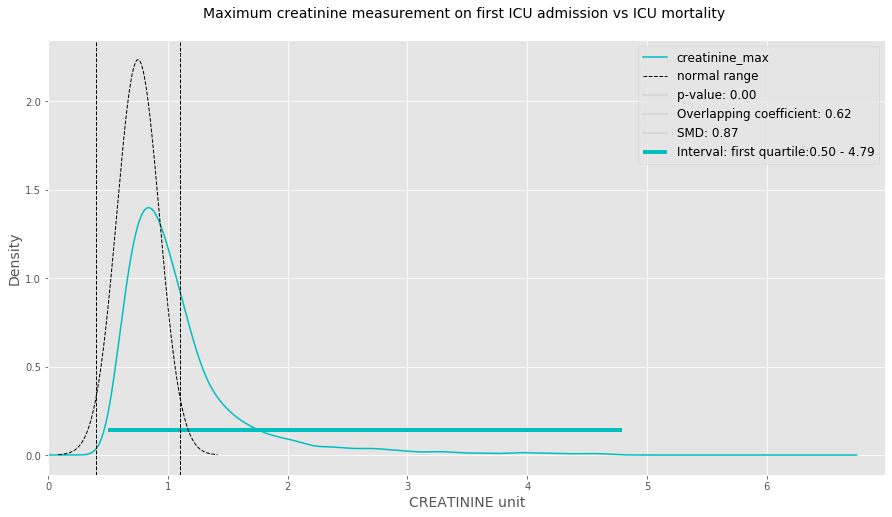

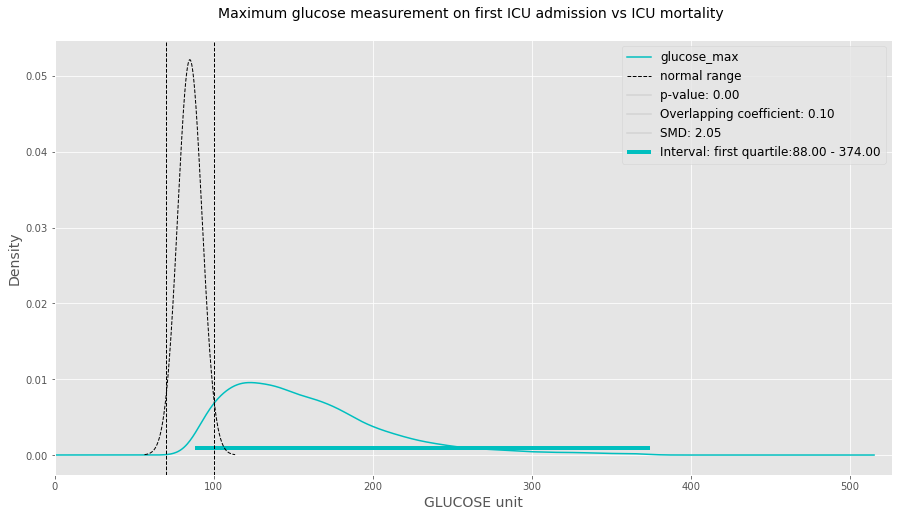

In [ ]:
### 2group_MAX
for i, u in iter(lab_unit.items()): 
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    #plot best out come dist
    n_surv = surv_data[i.lower() + '_max'].dropna().count()
    quarter = n_surv /4
    quarter = int(quarter)
    cond = data.mort_icu == 0
    best_group = surv_data.sort_values(by=['los'])[i.lower()+'_max'].dropna().head(quarter)
    [q1, q2] = best_group.quantile(q = [0.025,0.975])
    best_group = best_group[best_group > q1]
    best_group = best_group[best_group < q2]
    
    
    #range for x and y
    plot_range = [min(q1,lab_ranges[i][0]),max(q2,lab_ranges[i][1])]
    diff = plot_range[1] - plot_range[0]
    #plt.xlim(max(plot_range[0] - 0.5*diff, 0), plot_range[1] + 0.5*diff)
    
    best_group.plot.kde(color='c', label=i.lower()+'_max', xlim= (max(plot_range[0] - 0.5*diff, 0), plot_range[1] + 0.5*diff))
    
    xs = np.linspace(plot_range[0], plot_range[1], 600)
    density = gaussian_kde(best_group)
    ys = density(xs)
    index = np.argmax(ys)
    maxy = ys[index]
  
    #plot best outcome interval
    #interval line
    plt.hlines(y=0.1*maxy, xmin = q1, xmax = q2, linewidth=4, linestyle='-', color='c', label='Interval: first quartile:{} - {}'.format(format(q1,'.2f'), format(q2,'.2f')))
    
    # plot normal range 
    plt.axvline(x=lab_ranges[i][0], linewidth=1, linestyle='--', color='k')
    plt.axvline(x=lab_ranges[i][1], linewidth=1, linestyle='--', color='k')
    
    
    # plot normal distribution with normal range
    norm_dist = ResumeNorm(lab_ranges[i][0], lab_ranges[i][1])
    x = np.linspace(norm_dist.ppf(0.0001),norm_dist.ppf(0.9999), 1000)
    ax.plot(x, norm_dist.pdf(x), 'k-',#color 'r-' red 'k-' black
            lw=1,#linewidth
            alpha=1,#RGBA transparency
            linestyle='--',
            label='normal range')
    ax.legend(loc='best', frameon=False)
    
    #MannWhitney test
    t_stat, p_val = mannwhitneyu(x, best_group)
    
    #standardized mean difference
    norm_sample = norm_dist.rvs(size=quarter, random_state=20200620)
    smd = cohen_d(best_group, norm_sample)
        
    #overlapping parameter
    best_group_dist = gaussian_kde(best_group)
    ovl = OverlapParam(best_group_dist, norm_dist)
        
    plt.plot([], label='p-value: {}'.format(format(p_val, '.2f')), color='lightgrey')
    plt.plot([], label='Overlapping coefficient: {}'.format(format(max(ovl), '.2f')), color='lightgrey')
    plt.plot([], label='SMD: {}'.format(format(smd, '.2f')), color='lightgrey')
    
    plt.title('Maximum {} measurement on first ICU admission '.format(i.lower()) +
                   'vs ICU mortality \n', fontsize=14)
    plt.xlabel(i + ' ' + 'unit', fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)
    plt.savefig("mimic_figure/2group/{}_MAX.png".format(i))
    plt.show()
    

(0.39823805933544665, 1.4402340013892467e-08)


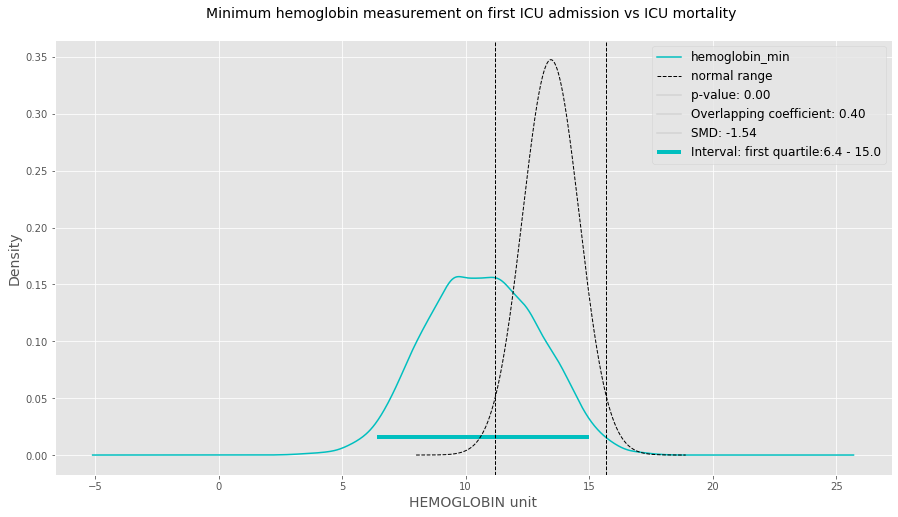

In [11]:
i = 'HEMOGLOBIN'

fig, ax = plt.subplots(figsize=(15,8))

#plot best out come dist
n_surv = surv_data[i.lower() + '_min'].dropna().count()
quarter = n_surv /4
quarter = int(quarter)
cond = data.mort_icu == 0
best_group = surv_data.sort_values(by=['los'])[i.lower()+'_min'].dropna().head(quarter)

[q1, q2] = best_group.quantile(q = [0.025,0.975])
#best_group = best_group[best_group > q1]
#best_group = best_group[best_group < q2] 


best_group.plot.kde(color='c', label=i.lower()+'_min')
#plot best outcome interval

#plot_range = [min(q1,lab_ranges[i][0]),max(q2,lab_ranges[i][1])]
plot_range = [lab_ranges[i][0],lab_ranges[i][1]]


diff = plot_range[1] - plot_range[0]
#plt.xlim(plot_range[0] - 0.5*diff, plot_range[1] + 0.5*diff)
xs = np.linspace(plot_range[0], plot_range[1], 600)
density = gaussian_kde(best_group)
ys = density(xs)
index = np.argmax(ys)
maxy = ys[index]

#interval line
plt.hlines(y=0.1*maxy, xmin = q1, xmax = q2, linewidth=4, linestyle='-', color='c', label='Interval: first quartile:{} - {}'.format(q1,q2))
    


# plot normal range 
plt.axvline(x=lab_ranges[i][0], linewidth=1, linestyle='--', color='k')
plt.axvline(x=lab_ranges[i][1], linewidth=1, linestyle='--', color='k')


# plot normal distribution with normal range
norm_dist = ResumeNorm(lab_ranges[i][0], lab_ranges[i][1])
x = np.linspace(norm_dist.ppf(0.000001),norm_dist.ppf(0.999999), 1000)
ax.plot(x, norm_dist.pdf(x), 'k-',#color 'r-' red 'k-' black
        lw=1,#linewidth
        alpha=1,#RGBA transparency
        linestyle='--',
        label='normal range')
ax.legend(loc='best', frameon=False)

#MannWhitney test
t_stat, p_val = mannwhitneyu(x, best_group)

#standardized mean difference

norm_sample = norm_dist.rvs(size=quarter, random_state=20200620)
smd = cohen_d(best_group, norm_sample)
    
#overlapping parameter
best_group_dist = gaussian_kde(best_group)
ovl = OverlapParam(best_group_dist, norm_dist)
print(ovl)
    
plt.plot([], label='p-value: {}'.format(format(p_val, '.2f')), color='lightgrey')
plt.plot([], label='Overlapping coefficient: {}'.format(format(max(ovl), '.2f')), color='lightgrey')
plt.plot([], label='SMD: {}'.format(format(smd, '.2f')), color='lightgrey')

plt.title('Minimum {} measurement on first ICU admission '.format(i.lower()) +
               'vs ICU mortality \n', fontsize=14)
plt.xlabel(i + ' ' + 'unit', fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(fontsize=12)
plt.show()




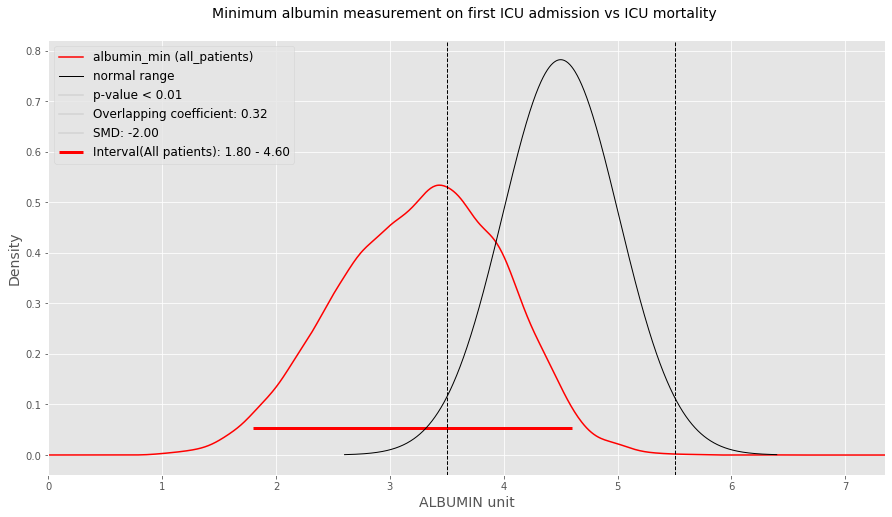

In [9]:

labs = {
        'ALBUMIN': 'g/dL', 
        #'BICARBONATE': 'mEq/L',
        #'BUN': 'mEq/L',
        #'CALCIUM': 'mg/dL',
        #'CHLORIDE': 'mEq/L',
        #'CREATININE': 'mEq/L',
        #'GLUCOSE': 'mg/dL',
        #'HEMOGLOBIN': 'g/dL',
        #'LACTATE': 'mmol/L',
        #'MAGNESIUM': 'mmol/L',
        #'PHOSPHATE': 'mg/dL',
        #'PLATELET': 'K/uL',
        #'POTASSIUM': 'mEq/L',
        #'SODIUM':'mmol/L',
        #'FREECALCIUM': 'mmol/L',
        #'WBC': ''
       }

for i, u in iter(labs.items()):
    
    
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    #plot best out come dist
    n_surv = surv_data[i.lower() + '_min'].dropna().count()
    n_all = data[i.lower() + '_min'].dropna().count()
    quarter = n_surv /4
    quarter = int(quarter)
    cond = data.mort_icu == 0
    all_patients = surv_data.sort_values(by=['los'])[i.lower()+'_min'].dropna()
    
    [q1, q2] = all_patients.quantile(q = [0.025,0.975])
    
    #best_group = best_group[best_group > q1]
    #best_group = best_group[best_group < q2]

    #range for x and y
    plot_range = [min(q1,lab_ranges[i][0]),max(q2,lab_ranges[i][1])]
    diff = plot_range[1] - plot_range[0]
    #plt.xlim(max(plot_range[0] - 0.5*diff, 0), plot_range[1] + 0.5*diff)
    
    all_patients.plot.kde(color='r', label=i.lower()+'_min (all_patients)', xlim= (max(plot_range[0] - 0.5*diff, 0), plot_range[1] + 0.5*diff))
    
    xs = np.linspace(plot_range[0], plot_range[1], 600)
    density = gaussian_kde(all_patients)
    ys = density(xs)
    index = np.argmax(ys)
    maxy = ys[index]
  
    #plot best outcome interval
    #interval line
    plt.hlines(y=0.1*maxy, xmin = q1, xmax = q2, linewidth=3, linestyle='-', color='r', label='Interval(All patients): {} - {}'.format(format(q1,'.2f'), format(q2,'.2f')))
    
    # plot normal range 
    plt.axvline(x=lab_ranges[i][0], linewidth=1, linestyle='--', color='k')
    plt.axvline(x=lab_ranges[i][1], linewidth=1, linestyle='--', color='k')
    
    
    # plot normal distribution with normal range
    norm_dist = ResumeNorm(lab_ranges[i][0], lab_ranges[i][1])
    x = np.linspace(norm_dist.ppf(0.0001),norm_dist.ppf(0.9999), 1000)
    ax.plot(x, norm_dist.pdf(x), 'k-',#color 'r-' red 'k-' black
            lw=1,#linewidth
            alpha=1,#RGBA transparency
            linestyle='-',
            label='normal range')
    ax.legend(loc='best', frameon=False)
    
    #MannWhitney test
    norm_sample = norm_dist.rvs(size=n_all, random_state=20200620)
    t_stat, p_val = mannwhitneyu(norm_sample, all_patients)
    
    #standardized mean difference
    smd = cohen_d(all_patients, norm_sample)
        
    #overlapping parameter
    all_patients_dist = gaussian_kde(all_patients)
    ovl = OverlapParam(all_patients_dist, norm_dist)
        
    if p_val < 0.01:
        plt.plot([], label='p-value < 0.01', color='lightgrey')
    else:
        plt.plot([], label='p-value: {}'.format(format(p_val, '.2f')), color='lightgrey')
    plt.plot([], label='Overlapping coefficient: {}'.format(format(max(ovl), '.2f')), color='lightgrey')
    plt.plot([], label='SMD: {}'.format(format(smd, '.2f')), color='lightgrey')
    
    plt.title('Minimum {} measurement on first ICU admission '.format(i.lower()) +
                   'vs ICU mortality \n', fontsize=14)
    plt.xlabel(i + ' ' + 'unit', fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)
    plt.savefig("mimic_figure/2group/ALL_{}_MIN.png".format(i))
    plt.show()
    

In [18]:
print(best_group.mean())
print(best_group.std())

10.68420632203583
2.2687971606947084
